# Inference on Hodgkin-Huxley model: tutorial

In this tutorial, we use `delfi` to do inference on a Hodgkin-Huxley model (Hodgkin and Huxley, 1952) with two parameters ($\bar g_{Na}$,$\bar g_K$), given a current-clamp recording (synthetically generated).

## Different required components

Before running inference, let us define the different required components:

(1) observed data

(2) model
    
(3) prior over model parameters
    
(4) summary statistics
    
(5) generator class.

## Observed data

Let us assume we current-clamped a neuron and recorded the following voltage trace:


<img align="left" src="observed_voltage_trace.png" width="480">

In fact, this voltage trace was not measured experimentally but synthetically generated by simulating a Hodgkin-Huxley model with particular parameters ($\bar g_{Na}$,$\bar g_K$). We will come back to this point later in the tutorial.

## Model

We would like to infer the posterior over the two parameters ($\bar g_{Na}$,$\bar g_K$) of a Hodgkin-Huxley model, given the observed electrophysiological recording above. The model has channel kinetics as in Pospischil et al. 2008, and is defined by the following set of differential equations (parameters of interest highlighted in orange):
\begin{align*}
\label{eq:HH}
C_m \frac{dV}{dt} &= g_{\text{l}}(E_{\text{l}} - V) + \color{orange}{\bar g_{\text{Na}}}m^3h(E_{\text{Na}}-V) + \color{orange}{\bar g_{\text{K}}}n^4(E_\text{K}-V) + \bar g_\text{M}p(E_\text{K}-V) + I_{\text{inj}} + \sigma \eta (t)\\
\frac{dq}{dt} &= \frac{q_{\infty}(V) - q}{\tau_{q}(V)}, q \in \{ m, h, n, p \},
\end{align*}
where $V$ is the membrane potential, $C_m$ is the membrane capacitance, $g_{\text{l}}$ is the leak conductance, $E_{\text{l}}$ is the membrane reversal potential, $\bar{g}_c$ is the density of channels of type $c$ ($\text{Na}^+$, $\text{K}^+$, M), $E_c$ is the reversal potential of $c$, ($m$, $h$, $n$, $p$) are the respective channel gating kinetic variables, and $\sigma \eta(t)$ is the intrinsic neural noise. The right hand side of the voltage dynamics is composed of a leak current, a voltage-dependent $\text{Na}^+$ current, a delayed-rectifier $\text{K}^+$ current, a slow voltage-dependent $\text{K}^+$ current responsible for spike-frequency adaptation, and an injected current $I_{\text{inj}}$. Channel gating variables $q$ have dynamics fully characterized by the neuron membrane potential $V$, given the respective steady-state $q_{\infty}(V)$ and time constant $\tau_{q}(V)$ (details in Pospischil et al. 2008).


The input current $I_{\text{inj}}$ is defined by:

In [1]:
import numpy as np

def syn_current(duration=120, dt=0.01, t_on = 10,
                curr_level = 5e-4, seed=None):
    t_offset = 0.
    duration = duration
    t_off = duration - t_on
    t = np.arange(0, duration+dt, dt)

    # external current
    A_soma = np.pi*((70.*1e-4)**2)  # cm2
    I = np.zeros_like(t)
    I[int(np.round(t_on/dt)):int(np.round(t_off/dt))] = curr_level/A_soma # muA/cm2

    return I, t_on, t_off, dt, t, A_soma

The Hodgkin-Huxley simulator is given by:

In [2]:
def HHsimulator(V0, params, dt, t, I, seed=None):
    """Simulates the Hodgkin-Huxley model for a specified time duration and current

        Parameters
        ---------- 
        V0 : float
            Voltage at first time step
        params : np.array, 1d of length dim_param
            Parameter vector
        dt : float
            Timestep
        t : array
            Numpy array with the time steps
        I : array
            Numpy array with the input current
        seed : int
        """

    gbar_Na = params[0,0]  # mS/cm2
    gbar_Na.astype(float)
    gbar_K = params[0,1]   # mS/cm2
    gbar_K.astype(float)

    # fixed parameters
    g_leak = 0.1    # mS/cm2
    gbar_M = 0.07   # mS/cm2
    tau_max = 6e2   # ms
    Vt = -60.       # mV
    nois_fact = 0.1 # uA/cm2
    E_leak = -70.   # mV
    C = 1.          # uF/cm2
    E_Na = 53       # mV
    E_K = -107      # mV

    tstep = float(dt)
    
    if seed is not None:
        rng = np.random.RandomState(seed=seed)
    else:
        rng = np.random.RandomState()

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z/2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.
        return 0.32*efun(-0.25*v1)/0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28*efun(0.2*v1)/0.2

    def alpha_h(x):
        v1 = x - Vt - 17.
        return 0.128*np.exp(-v1/18.)

    def beta_h(x):
        v1 = x - Vt - 40.
        return 4.0/(1 + np.exp(-0.2*v1))

    def alpha_n(x):
        v1 = x - Vt - 15.
        return 0.032*efun(-0.2*v1)/0.2

    def beta_n(x):
        v1 = x - Vt - 10.
        return 0.5*np.exp(-v1/40)

    # steady-states and time constants
    def tau_n(x):
         return 1/(alpha_n(x) + beta_n(x))
    def n_inf(x):
        return alpha_n(x)/(alpha_n(x) + beta_n(x))
    def tau_m(x):
        return 1/(alpha_m(x) + beta_m(x))
    def m_inf(x):
        return alpha_m(x)/(alpha_m(x) + beta_m(x))
    def tau_h(x):
        return 1/(alpha_h(x) + beta_h(x))
    def h_inf(x):
        return alpha_h(x)/(alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.
        return 1.0/(1. + np.exp(-0.1*v1))

    def tau_p(x):
        v1 = x + 35.
        return tau_max/(3.3*np.exp(0.05*v1) + np.exp(-0.05*v1))


    ####################################
    # simulation from initial point
    V = np.zeros_like(t) # voltage
    n = np.zeros_like(t)
    m = np.zeros_like(t)
    h = np.zeros_like(t)
    p = np.zeros_like(t)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, t.shape[0]):
        tau_V_inv = ( (m[i-1]**3)*gbar_Na*h[i-1]+(n[i-1]**4)*gbar_K+g_leak+gbar_M*p[i-1] )/C
        V_inf = ( (m[i-1]**3)*gbar_Na*h[i-1]*E_Na+(n[i-1]**4)*gbar_K*E_K+g_leak*E_leak+gbar_M*p[i-1]*E_K
                +I[i-1]+nois_fact*rng.randn()/(tstep**0.5) )/(tau_V_inv*C)
        V[i] = V_inf + (V[i-1]-V_inf)*np.exp(-tstep*tau_V_inv)
        n[i] = n_inf(V[i])+(n[i-1]-n_inf(V[i]))*np.exp(-tstep/tau_n(V[i]))
        m[i] = m_inf(V[i])+(m[i-1]-m_inf(V[i]))*np.exp(-tstep/tau_m(V[i]))
        h[i] = h_inf(V[i])+(h[i-1]-h_inf(V[i]))*np.exp(-tstep/tau_h(V[i]))
        p[i] = p_inf(V[i])+(p[i-1]-p_inf(V[i]))*np.exp(-tstep/tau_p(V[i]))

    return np.array(V).reshape(-1,1)

To get an idea of the output of the Hodgkin-Huxley model, let us generate some voltage traces for different parameters ($\bar g_{Na}$,$\bar g_K$), given the input current $I_{\text{inj}}$:

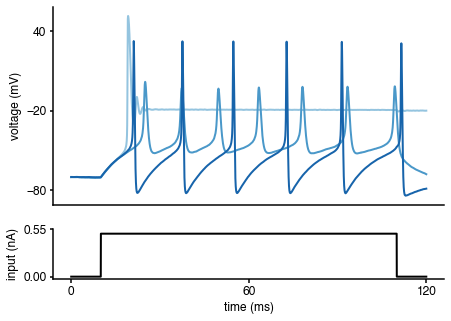

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# input current, time step, time array
I, t_on, t_off, dt, t, A_soma = syn_current()

# simulate Hodgkin-Huxley model for 3 different parameter sets
params = np.array([[[50., 1.]],[[4., 1.5]],[[20., 15.]]])
num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples,len(I)))
for i in range(num_samples):
    sim_samples[i,:] = HHsimulator(V0=-70,params=params[i,:],dt=dt,t=t,I=I,seed=None)[:,0]


# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

# plotting
%matplotlib inline

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

As can be seen, the voltage traces can be quite diverse for different parameter values. How can we infer the parameters ($\bar g_{Na}$,$\bar g_K$) underlying the particular observed voltage trace? `delfi` will allow us to solve this problem.

In order to run the Hodgkin-Huxley simulator within `delfi`, we need to define a simulator class linking to the simulator:

In [4]:
from delfi.simulator.BaseSimulator import BaseSimulator

class HodgkinHuxley(BaseSimulator):
    def __init__(self, I, dt, V0, seed=None):
        """Hodgkin-Huxley simulator

        Parameters
        ----------
        I : array
            Numpy array with the input current
        dt : float
            Timestep
        V0 : float
            Voltage at first time step
        seed : int or None
            If set, randomness across runs is disabled
        """
        dim_param = 2

        super().__init__(dim_param=dim_param, seed=seed)
        self.I = I
        self.dt = dt
        self.t = np.arange(0, len(self.I), 1)*self.dt
        self.HHsimulator = HHsimulator
        self.init = V0

    def gen_single(self, params):
        """Forward model for simulator for single parameter set

        Parameters
        ----------
        params : list or np.array, 1d of length dim_param
            Parameter vector

        Returns
        -------
        dict : dictionary with data
            The dictionary must contain a key data that contains the results of
            the forward run. Additional entries can be present.
        """
        params = np.asarray(params)

        assert params.ndim == 1, 'params.ndim must be 1'

        hh_seed = self.gen_newseed()

        states = self.HHsimulator(self.init, params.reshape(1, -1), self.dt, self.t, self.I, seed=hh_seed)

        return {'data': states.reshape(-1),
                'time': self.t,
                'dt': self.dt,
                'I': self.I.reshape(-1)}

Note that the simulator class simply wraps the simulator function we set up previously. `delfi` has the flexibility to use simulators that utilize external packages, e.g., Brian (http://briansimulator.org/), nest (https://www.nest-simulator.org/), or NEURON (https://neuron.yale.edu/neuron/). External simulators do not need to be Python-based as long as they store simulation outputs in a format that can be read from Python.

## Prior over model parameters

Now that we have the model and simulator class, we need to define a function with the prior over the model parameters ($\bar g_{Na}$,$\bar g_K$), which in this case is chosen to be a Uniform distribution:

In [5]:
import delfi.distribution as dd

seed_p = 2
prior_min = np.array([.5,1e-4])
prior_max = np.array([80.,15.])
prior = dd.Uniform(lower=prior_min, upper=prior_max,seed=seed_p)

## Summary statistics

We want to fit a set of summary statistics of the observed data: number of spikes, mean resting potential, standard deviation of the resting potential, and the first 4 voltage moments, mean, standard deviation, skewness and kurtosis. In order to do accomplish that, we define a summary statistics class which computes those quantities:

In [6]:
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
from scipy import stats as spstats

class HodgkinHuxleyStats(BaseSummaryStats):
    """Moment based SummaryStats class for the Hodgkin-Huxley model

    Calculates summary statistics
    """
    def __init__(self, t_on, t_off, n_mom=4, n_summary=7, seed=None):
        """See SummaryStats.py for docstring"""
        super(HodgkinHuxleyStats, self).__init__(seed=seed)
        self.t_on = t_on
        self.t_off = t_off
        self.n_mom = n_mom
        self.n_summary = np.minimum(n_summary,n_mom + 3)

    def calc(self, repetition_list):
        """Calculate summary statistics

        Parameters
        ----------
        repetition_list : list of dictionaries, one per repetition
            data list, returned by `gen` method of Simulator instance

        Returns
        -------
        np.array, 2d with n_reps x n_summary
        """
        stats = []
        for r in range(len(repetition_list)):
            x = repetition_list[r]

            N = x['data'].shape[0]
            t = x['time']
            dt = x['dt']
            t_on = self.t_on
            t_off = self.t_off

            # initialise array of spike counts
            v = np.array(x['data'])

            # put everything to -10 that is below -10 or has negative slope
            ind = np.where(v < -10)
            v[ind] = -10
            ind = np.where(np.diff(v) < 0)
            v[ind] = -10

            # remaining negative slopes are at spike peaks
            ind = np.where(np.diff(v) < 0)
            spike_times = np.array(t)[ind]
            spike_times_stim = spike_times[(spike_times > t_on) & (spike_times < t_off)]

            # number of spikes
            if spike_times_stim.shape[0] > 0:
                spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim))>0.5]

            # resting potential and std
            rest_pot = np.mean(x['data'][t<t_on])
            rest_pot_std = np.std(x['data'][int(.9*t_on/dt):int(t_on/dt)])

            # moments
            std_pw = np.power(np.std(x['data'][(t > t_on) & (t < t_off)]),
                              np.linspace(3,self.n_mom,self.n_mom-2))
            std_pw = np.concatenate((np.ones(1),std_pw))
            moments = spstats.moment(x['data'][(t > t_on) & (t < t_off)],
                                     np.linspace(2,self.n_mom,self.n_mom-1))/std_pw

            # concatenation of summary statistics
            sum_stats_vec = np.concatenate((
                    np.array([spike_times_stim.shape[0]]),
                    np.array([rest_pot,rest_pot_std,np.mean(x['data'][(t > t_on) & (t < t_off)])]),
                    moments
                ))
            sum_stats_vec = sum_stats_vec[0:self.n_summary]

            stats.append(sum_stats_vec)

        return np.asarray(stats)

## Generator class

Now that we have the simulator class, the prior over parameters and the summary statistics class, we need to define a generator class that binds all these objects together:

In [7]:
import delfi.generator as dg

# input current, time step
I, t_on, t_off, dt, t, A_soma = syn_current()

# initial voltage
V0 = -70

# seeds
seed_m = 1

# summary statistics hyperparameters
n_mom = 4
n_summary = 7

# define model, prior, summary statistics and generator classes
seed = 3
m = HodgkinHuxley(I, dt, V0=V0, seed=seed_m)
s = HodgkinHuxleyStats(t_on=t_on, t_off=t_off, n_mom=n_mom, n_summary=n_summary)
g = dg.Default(model=m, prior=prior, summary=s)

Note that `delfi` allows for the use of multiprocessing tools to parallelise the simulations and increase the speed of simulations. As the simulations typically constitute the major computational burden in `SNPE`, we suggest the use of parallelisation. In order to accomplish that, we need to decide on the number of parallel processes (according to the computational resources available to the user - here we chose 10 parallel processes), define a list of as many models as the number of processes, and call `MPGenerator` class instead of `Default`:

In [8]:
n_processes = 10

seeds_m = np.arange(1,n_processes+1,1)
m = []
for i in range(n_processes):
    m.append(HodgkinHuxley(I, dt, V0=V0, seed=seeds_m[i]))
g = dg.MPGenerator(models=m, prior=prior, summary=s)

## Coming back to the observed data

As mentioned at the beginning of the tutorial, the observed data are generated by the Hodgkin-Huxley model with a set of known parameters ($\bar g_{Na}$,$\bar g_K$). To illustrate how to compute the summary statistics of the observed data, let us regenerate the observed data:

In [9]:
# true parameters and respective labels
true_params = np.array([50., 5.])       
labels_params = [r'$g_{Na}$', r'$g_{K}$']

# observed data: simulation given true parameters
obs = m[0].gen_single(true_params)

Replotting the observed data with the respective current input:

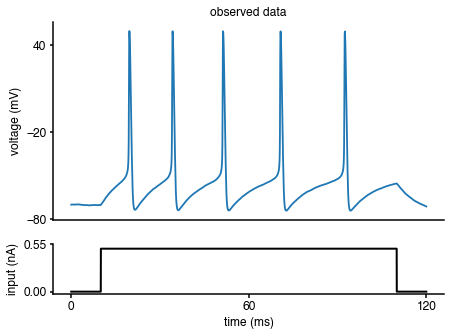

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
plt.plot(obs['time'],obs['data'])
plt.ylabel('voltage (mV)')
plt.title('observed data')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(obs['time'],I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(obs['time'])/2, max(obs['time'])])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

Let us compute the summary statistics of the observed data:

In [11]:
obs_stats = s.calc([obs])

# Inference

Now that we have all the required components, we can run inference with `SNPE`. Let us start by defining the inference hyperparameters:

In [12]:
seed_inf = 1

pilot_samples = 2000

# training schedule
n_train = 2000
n_rounds = 1

# fitting setup
minibatch = 100
epochs = 100
val_frac = 0.05

# network setup
n_hiddens = [50,50]

# convenience
prior_norm = True

# MAF parameters
density = 'maf'
n_mades = 5         # number of MADES

Note that we chose to run SNPE where the density estimator is a masked autoregressive flow (MAF). Another option could have been a mixture of Gaussians (see http://www.mackelab.org/delfi/reference/neuralnet/ ). We can now run the inference algorithm. Note that this step can take less than one minute to up to one hour depending on the computational resources available and the number of processes defined above:

In [ ]:
import delfi.inference as infer

# inference object
res = infer.SNPEC(g,
                obs=obs_stats,
                n_hiddens=n_hiddens,
                seed=seed_inf,
                pilot_samples=pilot_samples,
                n_mades=n_mades,
                prior_norm=prior_norm,
                density=density)

# train
log, _, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)

Note that we chose the algorithm `SNPE-C`, but other algorithms are available within `delfi` (see http://www.mackelab.org/delfi/reference/inference/). 

## Analysis of the results

After running the inference algorithm, let us inspect and analyse the results. We can start by checking whether the algorithm training has converged by inspecting the respective loss function:

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.plot(log[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss');

It seems that the loss function has converged. Let us inspect the inferred posterior distribution over the parameters ($\bar g_{Na}$,$\bar g_K$):

In [ ]:
from delfi.utils.viz import samples_nd

prior_min = g.prior.lower
prior_max = g.prior.upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

posterior_samples = posterior[0].gen(10000)

###################
# colors
hex2rgb = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# RGB colors in [0, 255]
col = {}
col['GT']      = hex2rgb('30C05D')
col['SNPE']    = hex2rgb('2E7FE8')
col['SAMPLE1'] = hex2rgb('8D62BC')
col['SAMPLE2'] = hex2rgb('AF99EF')

# convert to RGB colors in [0, 1]
for k, v in col.items():
    col[k] = tuple([i/255 for i in v])

###################
# posterior
fig, axes = samples_nd(posterior_samples,
                       limits=prior_lims,
                       ticks=prior_lims,
                       labels=labels_params,
                       fig_size=(5,5),
                       diag='kde',
                       upper='kde',
                       hist_diag={'bins': 50},
                       hist_offdiag={'bins': 50},
                       kde_diag={'bins': 50, 'color': col['SNPE']},
                       kde_offdiag={'bins': 50},
                       points=[true_params],
                       points_offdiag={'markersize': 5},
                       points_colors=[col['GT']],
                       title='');

As can be seen, the inferred posterior contains the ground-truth parameters (green) in a high-probability region. Now, let us sample parameters from the posterior distribution, simulate the Hodgkin-Huxley model for each of those samples and compare the simulations with the observed data:

In [ ]:
fig = plt.figure(figsize=(7,5))

y_obs = obs['data']
t = obs['time']
duration = np.max(t)

num_samp = 2

# sample from posterior
x_samp = posterior[0].gen(n_samples=num_samp)

# reject samples for which prior is zero
ind = (x_samp > prior_min) & (x_samp < prior_max)
params = x_samp[np.prod(ind,axis=1)==1]

num_samp = len(params[:,0])

# simulate and plot samples
V = np.zeros((len(t),num_samp))
for i in range(num_samp):
    x = m[0].gen_single(params[i,:])
    V[:,i] = x['data']
    plt.plot(t, V[:, i], color = col['SAMPLE'+str(i+1)], lw=2, label='sample '+str(num_samp-i))

# plot observation
plt.plot(t, y_obs, '--',lw=2, label='observation')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc='upper right')

ax.set_xticks([0, duration/2, duration])
ax.set_yticks([-80, -20, 40]);

As can be seen, the samples from the inferred posterior lead to simulations that closely resemble the observed data, confirming that `SNPE-C` did a good job at capturing the observed data.

## References


A. L. Hodgkin and A. F. Huxley. A quantitative description of membrane current and its application to conduction and excitation in nerve. The Journal of Physiology, 117(4):500–544, 1952.

M. Pospischil, M. Toledo-Rodriguez, C. Monier, Z. Piwkowska, T. Bal, Y. Frégnac, H. Markram, and A. Destexhe. Minimal Hodgkin-Huxley type models for different classes of cortical and thalamic neurons. Biological Cybernetics, 99(4-5), 2008.